# Linear Regression by Gradient Descent with Regularization

This homework consists of three parts. First, your task is to implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir.

Second, you will go through some diagnostics of debugging learning algorithms and examine theeffects of underfitting vs. overfitting.

Third, The problem with our linear model was that it was too simple for the data and led to underfitting. In this part, you will address this problem by adding more features.

(Programming assignments that I implemented in python of Machine Learning Course (it uses Octave/MATLAB).)

In [122]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.io import loadmat

# Explore data

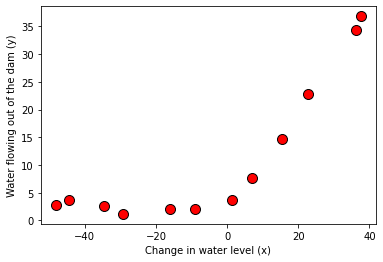

In [123]:
data = loadmat('hw4_data (1).mat')

X, y = data['X'], data['y'][:, 0]
Xtest, ytest = data['Xtest'], data['ytest'][:, 0]
Xval, yval = data['Xval'], data['yval'][:, 0]

m = y.size

plt.plot(X, y, 'ro', ms=10, mec='k', mew=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)');

In [124]:
df = pd.DataFrame(data = {'water_level': data['X'].T[0], 'water_flowing': data['y'].T[0]})
df.T

,0,1,2,3,4,5,6,7,8,9,10,11
water_level,-15.936758,-29.152979,36.189549,37.492187,-48.058829,-8.941458,15.307793,-34.706266,1.389154,-44.383760,7.013502,22.762749
water_flowing,2.134311,1.173257,34.359109,36.837955,2.808965,2.121072,14.710268,2.614184,3.740172,3.731691,7.627659,22.752428


# Regularized linear regression cost function


In [127]:
def linear_regression_cost(X, y, theta, lambda_r):
    m = X.shape[0]
    h = X.dot(theta)
    
    # Cost Function
    J = (1/(2*m)) * ((h-y).T.dot(h-y)) + (lambda_r/(2*m)) * np.sum(theta[1:,:]**2)
    return J

In [128]:
theta = np.ones(shape=(X.shape[1],1))
m = len(df)
X = np.hstack((np.ones((m,1)), df.water_level.values.reshape(-1,1)))
y = df.water_flowing.values.reshape(-1,1)
J = linear_regression_cost(X, y, theta, 1)
print('Cost at theta = [1 ; 1]:', J, '\n(this value should be about 303.993192)')

Cost at theta = [1 ; 1]: [[303.99319222]] 
(this value should be about 303.993192)


# Regularized Linear Regression Gradient

In [129]:
def linear_regression_cost_Gradient(theta, X, y, lambda_r):
    m = X.shape[0]
    theta = theta[:, np.newaxis] 
    
    h = X.dot(theta)
    J = (1/(2*m)) * ((h-y).T.dot(h-y)) + (lambda_r/(2*m)) * np.sum(theta[1:,:]**2)
    
    grad = (1/m) * (h-y).T.dot(X) + (lambda_r/m) * theta.T
    grad[0, 0] = (1/m) * (h-y).T.dot(X[:,0])
    return J, grad

In [130]:
theta = np.ones(shape=(X.shape[1]))
J, grad = linear_regression_cost_Gradient(theta, X, y, 1);
print('Gradient at theta = [1 ; 1]:', grad, '\n(this value should be about [-15.303016; 598.250744]')

Gradient at theta = [1 ; 1]: [[-15.30301567 598.25074417]] 
(this value should be about [-15.303016; 598.250744]


# Fitting Linear Regression

In [131]:
import scipy.optimize as opt
def train_linear_regression(X, y, lambda_r):
    theta = np.ones(shape=(X.shape[1]))
    opt_results = opt.minimize(linear_regression_cost_Gradient, theta, args=(X, y, lambda_r), 
                                method='L-BFGS-B', jac=True, options={'maxiter':200})
    return opt_results['x']

In [132]:
lambda_r = 0
theta_final = train_linear_regression(X, y, lambda_r)

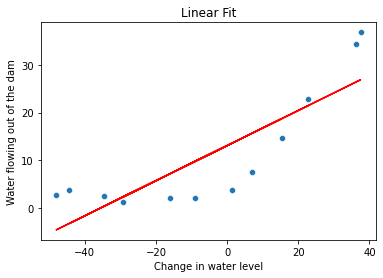

In [133]:
ax = sns.scatterplot(x='water_level', y='water_flowing', data=df)
plt.plot(X[:,1], X.dot(theta_final), color='r')
ax.set(xlabel='Change in water level', ylabel='Water flowing out of the dam', title='Linear Fit');

# 2. Bias-variance
- High bias: underfitting
- High variance: overfitting

In [134]:
df_val = pd.DataFrame(data = {'water_level': data['Xval'].T[0], 'water_flowing': data['yval'].T[0]})
df_val.T

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
water_level,-16.746536,-14.577471,34.515759,-47.010076,36.975119,-40.68611,-4.472011,26.533635,-42.797683,25.374099,...,27.311769,-3.263862,-1.818276,-40.719662,-50.013244,-17.411772,3.588194,7.085480,46.282369,14.612289
water_flowing,4.170202,4.067263,31.873068,10.623656,31.836021,4.95937,4.451599,22.276318,-0.000044,20.503802,...,19.365053,4.883763,11.097159,7.461708,1.476935,2.719164,10.926901,8.348712,52.781928,13.357340


In [135]:
Xval = df_val.water_level.values.reshape(-1,1)
Xval = np.hstack((np.ones((Xval.shape[0],1)), Xval))
yval = df_val.water_flowing.values.reshape(-1,1)

In [136]:
# Plots training and validation error as a function of training set size.

def learning_curve(X, y, Xval, yval, lambda_r):
    m = X.shape[0]
    error_train = np.zeros((m,1))
    error_val = np.zeros((m,1))
    for i in range(1,m):
        theta = train_linear_regression(X[:i, :], y[:i], lambda_r)
        error_train[i], _ = linear_regression_cost_Gradient(theta, X[:i,:], y[:i], 0)
        error_val[i], _ = linear_regression_cost_Gradient(theta, Xval, yval, 0)
    return error_train, error_val

In [137]:
lambda_r = 0
error_train, error_val = learning_curve(X, y, Xval, yval, lambda_r)

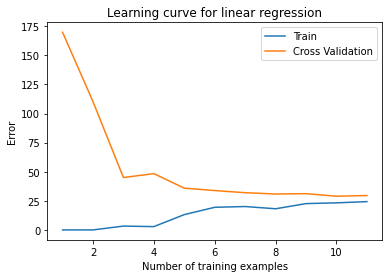

In [138]:
sns.lineplot(x=range(1,m), y=error_train.T[0][1:])
ax = sns.lineplot(x=range(1,m), y=error_val.T[0][1:])
ax.set(xlabel='Number of training examples', ylabel='Error', title='Learning curve for linear regression');
ax.legend(['Train', 'Cross Validation']);

In [139]:
df_error = pd.DataFrame(data={'error_train': error_train.T[0][1:], 'error_val': error_val.T[0][1:]})
df_error.T

,0,1,2,3,4,5,6,7,8,9,10
error_train,9.860761e-32,3.334883e-15,3.286595,2.842678,13.154049,19.443963,20.098522,18.172859,22.609405,23.261462,24.31725
error_val,1.698707e+02,1.103004e+02,45.010231,48.368911,35.865163,33.829961,31.970985,30.862444,31.135997,28.936204,29.55143


Both train error and cross validation error are high when the number of training examples is increased, that is, high bias problem, the model is too simple and unable to fit the dataset.

# Polynomial Regression
We can add more features to try to solve the underfitting problem.

In [140]:
def poly_features(X, p):
    X_poly = np.zeros((X.shape[0], p))
    for i in range(p):
        X_poly[:,i] = X**(i+1)
    return X_poly

### Learning Polynomial Regression
Normalizing features:

In [143]:
def feature_normalize(X, mean=np.zeros(1), std=np.zeros(1)):
    X = np.array(X)
    if len(mean.shape) == 1 or len(std.shape) == 1:
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0, ddof=1)

    X = (X - mean) / std
    return X, mean, std

In [144]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = poly_features(data['X'].T[0], p)
X_poly, mu, sigma = feature_normalize(X_poly)
X_poly = np.hstack((np.ones((X_poly.shape[0],1)), X_poly))

In [147]:
# Map X_poly_test and normalize (using mu and sigma)

X_poly_test = poly_features(data['Xtest'].T[0], p)
X_poly_test, _, _ = feature_normalize(X_poly_test, mu, sigma)
X_poly_test = np.hstack((np.ones((X_poly_test.shape[0],1)), X_poly_test))

In [148]:
# Map X_poly_val and normalize (using mu and sigma)

X_poly_val = poly_features(data['Xval'].T[0], p)
X_poly_val, _, _ = feature_normalize(X_poly_val, mu, sigma)
X_poly_val = np.hstack((np.ones((X_poly_val.shape[0], 1)), X_poly_val))

In [149]:
def train_and_plot_fit_learning_curve(X, X_poly, y, X_poly_val, yval, lambda_r):
    theta = train_linear_regression(X_poly, y, lambda_r)

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    ax = sns.scatterplot(x=X[:,1], y=y.T[0])
    x = np.arange(np.min(X)-15.0, np.max(X)+25.0, 0.05)
    plot_X_poly = poly_features(x, p)
    plot_X_poly, _, _ = feature_normalize(plot_X_poly, mu, sigma)
    plot_X_poly = np.hstack((np.ones((plot_X_poly.shape[0],1)), plot_X_poly))
    plt.plot(x, plot_X_poly.dot(theta), 'k--', color='r')
    ax.set(xlabel='Change in water level', ylabel='Water flowing out of the dam', 
           title='Polynomial Regression Fit ($\lambda$ = {})'.format(lambda_r));
    
    error_train, error_val = learning_curve(X_poly, y, X_poly_val, yval, lambda_r)
    plt.subplot(122)
    sns.lineplot(x=range(1,m), y=error_train.T[0][1:])
    ax = sns.lineplot(x=range(1,m), y=error_val.T[0][1:])
    ax.set(xlabel='Number of training examples', ylabel='Error', 
           title='Polynomial Regression Learning Curve ($\lambda$ = {})'.format(lambda_r));
    ax.legend(['Train', 'Cross Validation']);
    
    plt.subplots_adjust(wspace=0.2)
    plt.show()

C:\Users\GAMER\AppData\Local\Temp\ipykernel_11464\3945065884.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, plot_X_poly.dot(theta), 'k--', color='r')


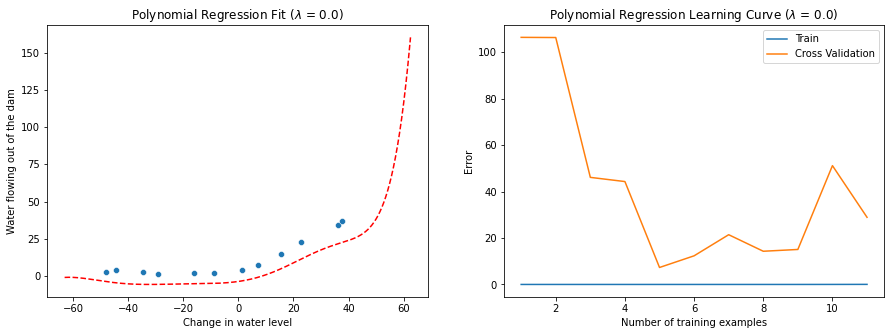

In [152]:
train_and_plot_fit_learning_curve(X, X_poly, y, X_poly_val, yval, lambda_r=0.0)

### Adjusting the regularization parameter

C:\Users\GAMER\AppData\Local\Temp\ipykernel_11464\3945065884.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, plot_X_poly.dot(theta), 'k--', color='r')


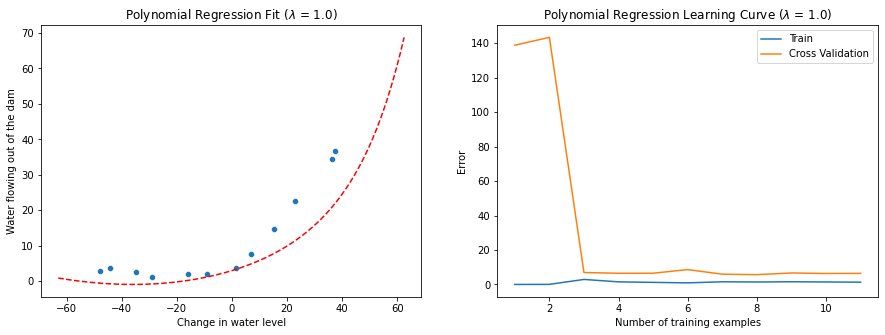

In [153]:
# lambda_r = 1.0
train_and_plot_fit_learning_curve(X, X_poly, y, X_poly_val, yval, lambda_r=1.0)

lambda = 1 model does not have the high-bias or high-variance problems

C:\Users\GAMER\AppData\Local\Temp\ipykernel_11464\3945065884.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, plot_X_poly.dot(theta), 'k--', color='r')


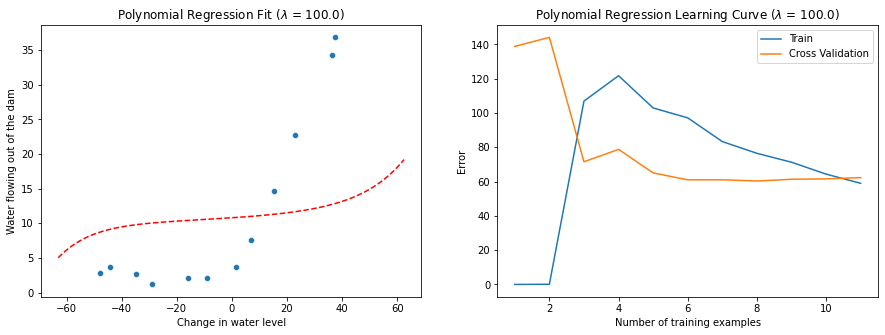

In [154]:
train_and_plot_fit_learning_curve(X, X_poly, y, X_poly_val, yval, lambda_r=100.0)

lambda = 100 the model is underfitting

### Selecting Lambda using a cross validation set

In [155]:
def validation_curve(X, y, Xval, yval):
    lambda_values = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    error_train = np.zeros((len(lambda_values),1))
    error_val = np.zeros((len(lambda_values),1))
    for i,l in enumerate(lambda_values):
        theta = train_linear_regression(X, y, l)
        error_train[i], _ = linear_regression_cost_Gradient(theta, X, y, 0)
        error_val[i], _ = linear_regression_cost_Gradient(theta, Xval, yval, 0)
    return lambda_values, error_train, error_val

In [156]:
lambda_values, error_train, error_val = validation_curve(X_poly, y, X_poly_val, yval)

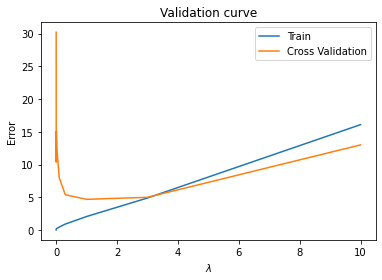

In [157]:
sns.lineplot(x=np.array(lambda_values), y=error_train.T[0])
ax = sns.lineplot(x=lambda_values, y=error_val.T[0])
ax.set(xlabel='$\lambda$', ylabel='Error', title='Validation curve');
ax.legend(['Train', 'Cross Validation']);

In [158]:
theta = train_linear_regression(X_poly, y, 3.0)
J, grad = linear_regression_cost_Gradient(theta, X_poly_test, data['ytest'], 0)
J

array([[11.64373681]])